### pyAPES_MLM: Multi-layer soil-vegetation-atmosphere transfer model

Demo how to:
1. Set-up the model
1. Run the model
1. Retrieve the results using xarray

In [1]:
# setting path
import sys
import os

from dotenv import load_dotenv
load_dotenv()
pyAPES_main_folder = os.getenv('pyAPES_main_folder')
sys.path.append(pyAPES_main_folder)
os.chdir(pyAPES_main_folder)

### Import modules

In [2]:
# function to read forcing data. See 'forcing/forcing_info.txt' for model forcing variable names and units!
from pyAPES.utils.iotools import read_forcing

# import the multi-layer model (mlm) driver
from pyAPES.pyAPES_MLM import driver

eps = 1e-16

### Read model parameter dictionaries

- mlm setup (parameterization, forcing file & run info) defined in: pyAPES.models.mlm_parameters
- output variables & logger configuration defined in: pyAPES.models.mlm_outputs. This is read by driver

In [3]:
# import parameter dictionaries
from pyAPES.parameters.Degero import gpara, cpara, spara # model configuration, canopy parameters, soil parameters

### Read forcing data and compile input for driver

- forcing is read into pd.DataFrame. Units must be correct!
- create parameter dictionary and provide it to driver

In [4]:
gpara['forc_filename'] = f'{pyAPES_main_folder}/forcing/Degero/Degero_forcing_2021-2023.dat'
gpara['start_time'] = '2021-09-01'
gpara['end_time'] = '2022-09-01'

forcing = read_forcing(
    forcing_file=gpara['forc_filename'],
    start_time=gpara['start_time'],
    end_time=gpara['end_time'],
    dt=gpara['dt']
)

params = {
    'general': gpara,   # model configuration
    'canopy': cpara,    # planttype, micromet, canopy, bottomlayer parameters
    'soil': spara,      # soil heat and water flow parameters
    'forcing': forcing  # forging data
}

### Run the model

In [5]:
resultfile, Model = driver(parameters=params,
                           create_ncf=True,
                           result_file= 'testrun.nc'
                          )

# alternative (for testing over short periods) is to return resuts in dictionary 'results'
# results, Model = driver(parameters=params,
#                         create_ncf=False,
#                         result_file=None
#                          )

INFO pyAPES.pyAPES_MLM driver pyAPES_MLM simulation started. Number of simulations: 1
INFO pyAPES.soil.water __init__ Water balance in soil solved using: RICHARDS EQUATION & no lateral drainage
INFO pyAPES.soil.heat __init__ Soil heat balance solved.
INFO pyAPES.canopy.mlm_canopy __init__ Eflow: True, WMA: False, Ebal: True
INFO pyAPES.microclimate.radiation __init__ Shortwave radiation model: ZHAOQUALLS
INFO pyAPES.microclimate.radiation __init__ Longwave radiation model: ZHAOQUALLS
INFO pyAPES.canopy.forestfloor __init__ Forestfloor: forest_moss, coverage 0.0 omitted!
INFO pyAPES.canopy.forestfloor __init__ Forestfloor: litter, coverage 0.0 omitted!
INFO pyAPES.canopy.forestfloor __init__ Forestfloor has 1 bottomlayer types
INFO pyAPES.pyAPES_MLM driver Running simulation number (start time 2026-02-26 15:33): 0
INFO pyAPES.pyAPES_MLM run Running simulation 0


0%.. 10%.. 20%.. 30%.. 40%.. 50%.. 60%.. 70%.. 80%.. 90%.. 

INFO pyAPES.pyAPES_MLM run Finished simulation 0, running time 1049.67 seconds
INFO pyAPES.pyAPES_MLM driver Running time 1049.67 seconds


100%


INFO pyAPES.pyAPES_MLM driver Ready! Results are in: results/testrun.nc


### Model run completed and results are in NetCDF-file.

### Read results using xarray
- we use function 'read_results' from pyAPES.utils.utils

- see https://docs.xarray.dev/en/stable/



In [6]:
from pyAPES.utils.iotools import read_results
import matplotlib.pyplot as plt

# read simulation restuls to xarray dataset
results = read_results(resultfile)

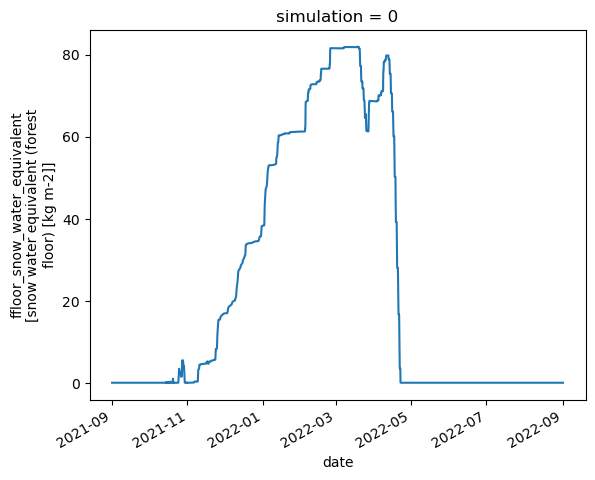

In [15]:
results['ffloor_snow_water_equivalent'].plot()

### Print resuts metadata:

Output variables are those defined at pyAPES.parameters.mlm_outputs'. Each variable contains one or several of following dimensions:

- date --> time dimension
- simulation --> simulation number. If there is only one, remember that it has index 0!
- canopy --> canopy and air layers. Index is 0 at ground and increases upwards
- planttype --> planttypes defined in mlm_parameters. Index follows the order in dict cpara['planttypes']) 
- soil -> soil layers. Index 0 is at the top and increases downwards (nr soil layers, 0 at top)
- groundtype --> groundtypes at forestfloor. Defined in mlm_parameters. Index follows the order in dict: cpara['forestfloor']['bottom_layer_types']


In [8]:
print(results)

# print list of all variables:
#vars = list(results.data_vars)
#for v in vars:
#    print(v)

<xarray.Dataset>
Dimensions:                               (date: 17521, simulation: 1,
                                           canopy: 101, planttype: 2, soil: 44,
                                           groundtype: 1)
Coordinates:
  * date                                  (date) datetime64[ns] 2021-09-01 .....
  * simulation                            (simulation) int64 0
  * soil                                  (soil) float32 -0.005 -0.015 ... -1.95
  * canopy                                (canopy) float32 0.0 0.25 ... 25.0
Dimensions without coordinates: planttype, groundtype
Data variables: (12/164)
    forcing_air_temperature               (date, simulation) float32 ...
    forcing_precipitation                 (date, simulation) float32 ...
    forcing_pressure                      (date, simulation) float32 ...
    forcing_h2o                           (date, simulation) float32 ...
    forcing_co2                           (date, simulation) float32 ...
    forcing_win

### Plot some model results

In [9]:
sim = 0  # in this demo, we have only one simulation (i.e. only one parameter set was used)

# grid variables for plotting
t = results.date  # time
zc = results.canopy_z  # height above ground [m]
zs = results.soil_z  # depth of soil; shown negative [m]

### Soil temperature and moisture

- computed using pyAPES.soil - package submodels 'Water' and 'Heat'
- model state at end of simulation is in: Model.soil.heat & Model.soil.water

In [10]:
# model state (last timestep)

#soilheat = Model.soil.heat
#vars(soilheat)  # list instance variables

#soilwater = Model.soil.water
#vars(soilwater) 

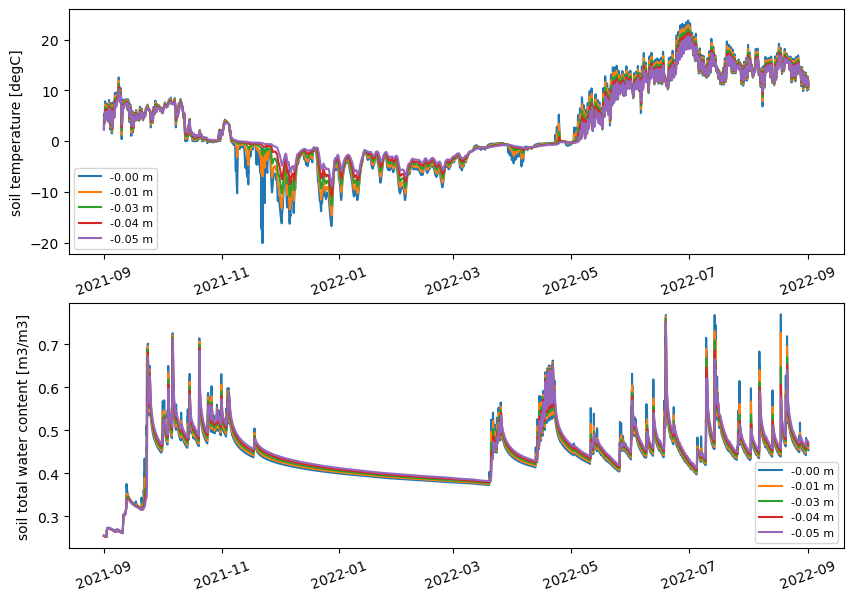

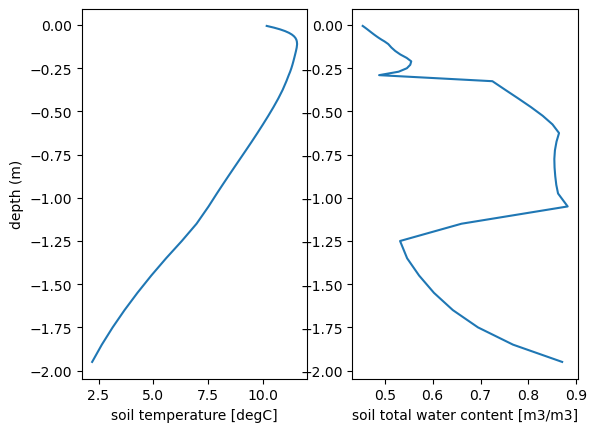

In [11]:
import numpy as np
var = ['soil_temperature', 'soil_volumetric_water_content']

lyrs = [0, 1, 2, 3, 4] # five top layers
#depths = np.array2string(np.asarray(zs[lyrs]), precision=1, separator=', ')
depths = ['{:.2f} m'.format(k) for k in zs[lyrs]]

fig, ax = plt.subplots(2, 1, figsize=(10,7))

k = 0
for v in var:
    ax[k].plot(t, results[v][:,sim,lyrs], label=depths)
    ax[k].set_ylabel(results[v].attrs['units'])
    ax[k].tick_params(axis='x', labelrotation = 20)
    ax[k].legend(fontsize=8)
    k += 1

# vertical profile at last timestep
fig, ax = plt.subplots(1, 2) #figsize=(10,5))

k = 0
for v in var:
    ax[k].plot(results[v][-1,sim,:], zs)
    ax[k].set_xlabel(results[v].attrs['units'])
    ax[0].set_ylabel('depth (m)')
    k += 1

### Ecosystem-scale fluxes

- ecosystem - atm. fluxes represent the integrated sinks / sources in soil (soil-module), forestfloor (bottomlayer-module) and vegetation (planttype&canopy -modules)
- comparable to ecosystem - atmosphere exchange
- affected by current model forcing and sub-model instance state (e.g. Planttype and Canopy LAI, phenology, soil temperature, moisture etc.)


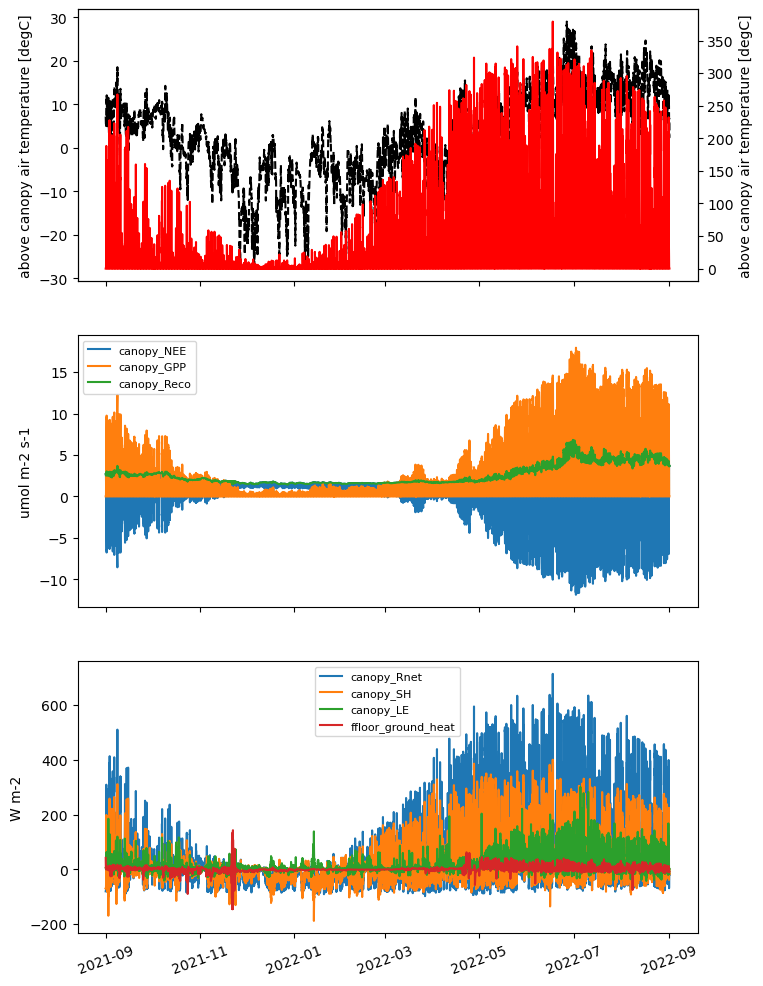

In [12]:

var = ['forcing_air_temperature', 'forcing_par', 'canopy_NEE', 'canopy_GPP', 
       'canopy_Reco', 'canopy_Rnet', 'canopy_SH', 'canopy_LE', 'ffloor_ground_heat']

fig, ax = plt.subplots(3, 1, figsize=(8,12), sharex=True)

# temperature & par
ax[0].plot(t, results[var[0]][:,sim], 'k--', label=var[0])
ax[0].set_ylabel(results[var[0]].attrs['units'])
ax[0].tick_params(axis='x', labelrotation = 20)
axb = ax[0].twinx()

axb.plot(t, results[var[1]][:,sim], 'r-', label=var[1]) # Par
axb.set_ylabel(results[var[0]].attrs['units'])

# CO2 fluxes
for v in var[2:5]:
    ax[1].plot(t, results[v][:,sim], label=v)

ax[1].set_ylabel('umol m-2 s-1')
ax[1].tick_params(axis='x', labelrotation = 20)
ax[1].legend(fontsize=8)

# energy fluxes
for v in var[5:]:
    ax[2].plot(t, results[v][:,sim], label=v)

ax[2].set_ylabel('W m-2')
ax[2].tick_params(axis='x', labelrotation = 20)
ax[2].legend(fontsize=8)



### Ecosystem radiation balance

- net radiation (Rnet) is the sum of net shortwave (SWnet = incoming - reflected) and net longwave (LWnet = incoming - emitted) radiation at canopy top
- computed via models in pyAPES.microclimate.radiation, called iteratively from pyAPES.canopy.mlm_canopy to account for canopy structure and leaf & forest floor temperature
- ecosystem albedo can be computed from radiation profiles at uppermost grid point

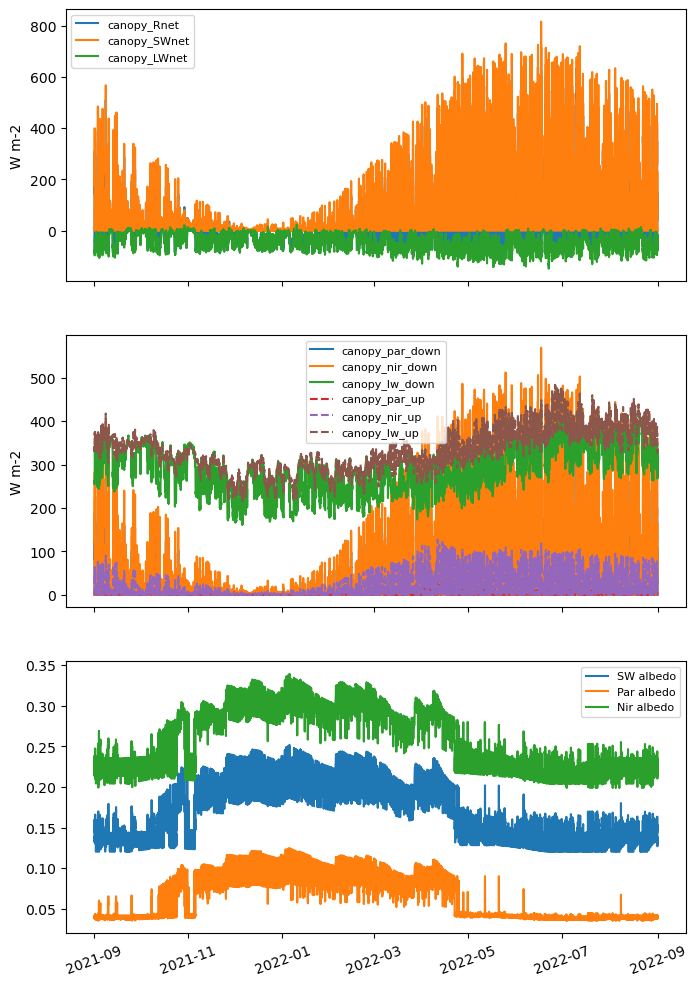

In [13]:
# net radiation components at canopy top
var = ['canopy_Rnet','canopy_SWnet', 'canopy_LWnet']
profs = ['canopy_par_down', 'canopy_par_up', 'canopy_nir_down','canopy_nir_up','canopy_lw_down','canopy_lw_up']

fig, ax = plt.subplots(3, 1, figsize=(8,12), sharex=True)

for v in var:
    ax[0].plot(t, results[v][:, sim], label=v)
ax[0].set_ylabel('W m-2')
ax[0].tick_params(axis='x', labelrotation = 20)
ax[0].legend(fontsize=8)    

# lets plot also partitioning of canopy_SWnet and canopy_LWnet.
# -1 is the index of uppermost gridpoint

for v in ['canopy_par_down', 'canopy_nir_down','canopy_lw_down']: # downward
    ax[1].plot(t, results[v][:,sim,-1], '-', label=v)
for v in ['canopy_par_up', 'canopy_nir_up','canopy_lw_up']: # upward
    ax[1].plot(t, results[v][:,sim,-1], '--', label=v)
ax[1].set_ylabel('W m-2')
ax[1].tick_params(axis='x', labelrotation = 20)
ax[1].legend(fontsize=8)

# canopy albedo
eps = 1e-16

# fraction of par on total SW
f_par = results['canopy_par_down'][:,sim,-1] / (results['canopy_par_down'][:,sim,-1] + results['canopy_nir_down'][:,sim,-1] + eps)

alb_par = results['canopy_par_up'][:,sim,-1] / (results['canopy_par_down'][:,sim,-1] + eps)
alb_nir = results['canopy_nir_up'][:,sim,-1] / (results['canopy_nir_down'][:,sim,-1] + eps)
alb_sw = f_par * alb_par + (1 - f_par) * alb_nir
alb_sw = np.maximum(0, np.minimum(1.0, alb_sw))

ax[2].plot(t, alb_sw, '-', label='SW albedo')
ax[2].plot(t, alb_par, '-', label='Par albedo')
ax[2].plot(t, alb_nir, '-', label='Nir albedo')

ax[2].tick_params(axis='x', labelrotation = 20)
ax[2].legend(fontsize=8)

### Microclimatic gradients within the canopy

- sub-models pyAPES.microclimate.Micromet & pyAPES.radiation.Radiation
- mean wind speed & friction velocity (momentum flux) profiles depend on momentum absorption in the canopy, which is proportional to leaf-area density (*lad*) profile. Canopy *lad* is sum of *lad* of each PlantType instance
- SW absorption depends on *lad* and leaf optical properties
- air-space scalar profiles (*T*, *H2O* & *CO2*) in steady-state with respective sink/source profile using 1st-order closure (K-theory)

Let's compute average profiles for daytime hours 10:00 -- 16:00 under conditions when canopy is dry


(array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))


IndexError: too many indices

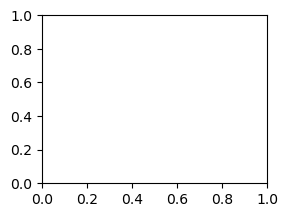

In [14]:
#par = results['forcing_par'][:,sim] # use PAR as criteria for night / day
ix = np.where((results.date.dt.hour>=10) & (results.date.dt.hour<=16) & (results['canopy_interception_storage'] <= eps))
print(ix)

rad = ['canopy_par']
mmet = ['canopy_wind_speed', 'canopy_friction_velocity', 'canopy_temperature', 'canopy_co2', 'canopy_h2o']

plt.figure('scalarprofiles')
n = 1
for v in var:
    plt.subplot(2,2,n)
    x = results[v][:, sim, :] - results[v][:, sim, -1] # s - s_ref
    xm = np.mean(x, axis=0)
    xmn = np.mean(x.loc[par < 20, :], axis=0) # night
    xmd = np.mean(x.loc[par > 200, :], axis=0) # day
    plt.plot(x, zcm, 'k', alpha=0.1)
    plt.plot(xmd, zc, 'r', label='day'); plt.plot(xmn, zc, 'b', label='night')
    plt.xlabel(results[v].attrs['units']); plt.ylabel(zc.attrs['units'])
    n += 1

plt.legend()


In [ ]:

ix = np.where((results.date.dt.hour>=10) & (results.date.dt.hour<=17))
print(ix)

ix = np.where((results.date.dt.hour>=10) & (results.date.dt.hour<=16) & (results['canopy_interception_storage'] <= eps))
print(ix)

In [ ]:
results.close()